In [1]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split,Dataset
import os
from torchvision.datasets.folder import default_loader
path='/kaggle/input/dog-vs-cat-classification/train/train'
test_path='/kaggle/input/dog-vs-cat-classification/test/test'


In [2]:
class Testdataset(Dataset):
    def __init__(self,root,transform):
        self.root=root
        self.transform=transform
        self.img_paths=sorted(os.path.join(self.root,x) for x in os.listdir(self.root) if x.endswith('jpg'))
    def __len__(self):
        return len(self.img_paths)
    def __getitem__(self, item):
        img_path=self.img_paths[item]
        sample=default_loader(img_path)
        if self.transform is not None:
            sample=self.transform(sample)
        return sample,img_path.split('/')[-1]

In [3]:
import torchvision
import torch
img_size=(224,224)
batch_size=64
data_transforms=torchvision.transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(img_size),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
])
test_set=Testdataset(test_path,transform=data_transforms)
alldataset=torchvision.datasets.ImageFolder(root=path,transform=data_transforms)
generator = torch.Generator().manual_seed(42)
train_set,valid_set=random_split(alldataset,[20000,5000],generator=generator)

train_loader=DataLoader(train_set,batch_size=batch_size,shuffle=True)
valid_loader=DataLoader(valid_set,batch_size=batch_size,shuffle=True)
test_loader=DataLoader(test_set,batch_size=batch_size,shuffle=False)

In [4]:
classname=alldataset.classes
classname

['cats', 'dogs']

In [5]:
a=alldataset.class_to_idx
print(a)

{'cats': 0, 'dogs': 1}


In [6]:
img_t,label_t=train_set[0]
# print(img_t)
# print('-'*50)
# print(label_t)

/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [7]:
img_load,label_load=next(iter(train_loader))
# print(img_load)
# print('-'*50)
# print(label_load)

In [8]:
from torch.nn import Linear

device='cuda' if torch.cuda.is_available() else 'cpu'
model=torchvision.models.efficientnet_b4(weights='EfficientNet_B4_Weights.IMAGENET1K_V1')
model.classifier[1]=Linear(in_features=1792,out_features=2,bias=True)
for param in model.parameters():
    param.requires_grad=False
for param in model.classifier.parameters():
    param.requires_grad=True
model.to(device)

Downloading: "https://download.pytorch.org/models/efficientnet_b4_rwightman-23ab8bcd.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b4_rwightman-23ab8bcd.pth
100%|██████████| 74.5M/74.5M [00:00<00:00, 88.0MB/s]


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=48, bias=False)
            (1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(48, 12, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(12, 48, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActiv

In [9]:
from torch.nn import CrossEntropyLoss
import torch.optim
loss_fn=CrossEntropyLoss()
optimizer=torch.optim.Adam(model.classifier.parameters(),lr=0.001)

In [10]:
len(valid_set),len(train_set)

(5000, 20000)

In [11]:
epochs=10
train_loss_set=[]
train_acc_set=[]
valid_loss_set=[]
valid_acc_set=[]
from tqdm.notebook import tqdm
for epoch in range(epochs):
    train_loss=0
    train_acc=0
    model.train()
    for i,(img_tensor,label) in enumerate(tqdm(train_loader,desc=f'第{epoch+1}轮训练开始')):
        img_tensor=img_tensor.to(device)
        label=label.to(device)
        out=model(img_tensor)
        loss=loss_fn(out,label)
        train_loss=train_loss+loss.item()
        acc=(out.argmax(1)==label).sum()
        train_acc=acc.item()+train_acc
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    train_loss=train_loss/len(train_loader)
    train_acc=train_acc/len(train_set)
    train_loss_set.append(train_loss)
    train_acc_set.append(train_acc)
    print(f'训练损失为:{train_loss},准确率为:{train_acc}')
    valid_loss=0
    valid_acc=0
    model.eval()
    with torch.no_grad():
        for j,(img_tensor,label) in enumerate(tqdm(valid_loader,desc=f'第{epoch+1}轮验证开始')):
            img_tensor = img_tensor.to(device)
            label = label.to(device)
            out = model(img_tensor)
            loss=loss_fn(out,label)
            acc=(out.argmax(1)==label).sum()
            valid_loss=valid_loss+loss.item()
            valid_acc=valid_acc+acc.item()
        valid_acc=valid_acc/len(valid_set)
        valid_loss=valid_loss/len(valid_loader)
        valid_acc_set.append(valid_acc)
        valid_loss_set.append(valid_loss)
        print(f'验证损失为:{valid_loss},准确率为:{valid_acc}')


第1轮训练开始:   0%|          | 0/313 [00:00<?, ?it/s]

训练损失为:0.21818009092689702,准确率为:0.9383


第1轮验证开始:   0%|          | 0/79 [00:00<?, ?it/s]

验证损失为:0.12016479770028138,准确率为:0.965


第2轮训练开始:   0%|          | 0/313 [00:00<?, ?it/s]

训练损失为:0.12836437120129124,准确率为:0.95375


第2轮验证开始:   0%|          | 0/79 [00:00<?, ?it/s]

验证损失为:0.09794455719522283,准确率为:0.97


第3轮训练开始:   0%|          | 0/313 [00:00<?, ?it/s]

训练损失为:0.11949640414870966,准确率为:0.95275


第3轮验证开始:   0%|          | 0/79 [00:00<?, ?it/s]

验证损失为:0.08984776128885112,准确率为:0.9712


第4轮训练开始:   0%|          | 0/313 [00:00<?, ?it/s]

训练损失为:0.11135330967628917,准确率为:0.9558


第4轮验证开始:   0%|          | 0/79 [00:00<?, ?it/s]

验证损失为:0.08336958991764468,准确率为:0.9698


第5轮训练开始:   0%|          | 0/313 [00:00<?, ?it/s]

训练损失为:0.1086348123884144,准确率为:0.95745


第5轮验证开始:   0%|          | 0/79 [00:00<?, ?it/s]

验证损失为:0.0835337366531544,准确率为:0.9718


第6轮训练开始:   0%|          | 0/313 [00:00<?, ?it/s]

训练损失为:0.10336043123310557,准确率为:0.95945


第6轮验证开始:   0%|          | 0/79 [00:00<?, ?it/s]

验证损失为:0.07958579523182369,准确率为:0.9728


第7轮训练开始:   0%|          | 0/313 [00:00<?, ?it/s]

训练损失为:0.103680854228834,准确率为:0.9602


第7轮验证开始:   0%|          | 0/79 [00:00<?, ?it/s]

验证损失为:0.08077771148255354,准确率为:0.9714


第8轮训练开始:   0%|          | 0/313 [00:00<?, ?it/s]

训练损失为:0.10145103915954551,准确率为:0.9593


第8轮验证开始:   0%|          | 0/79 [00:00<?, ?it/s]

验证损失为:0.07547361411955915,准确率为:0.974


第9轮训练开始:   0%|          | 0/313 [00:00<?, ?it/s]

训练损失为:0.1034635274102703,准确率为:0.95965


第9轮验证开始:   0%|          | 0/79 [00:00<?, ?it/s]

验证损失为:0.07440976355861448,准确率为:0.9732


第10轮训练开始:   0%|          | 0/313 [00:00<?, ?it/s]

训练损失为:0.10249656210311305,准确率为:0.95895


第10轮验证开始:   0%|          | 0/79 [00:00<?, ?it/s]

验证损失为:0.075773652124254,准确率为:0.9734


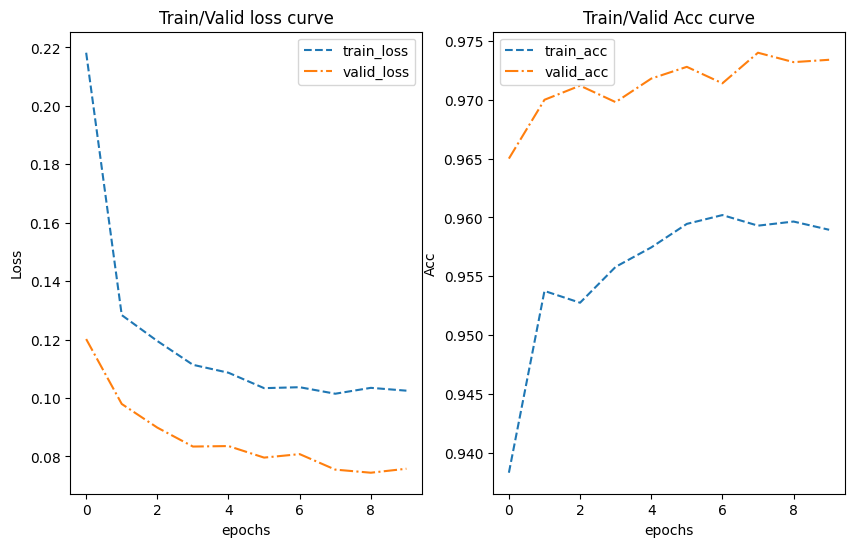

In [12]:
import matplotlib.pyplot as plt
import numpy as np
epochs=np.arange(0,epochs)
fig,axes=plt.subplots(nrows=1,ncols=2,figsize=(10,6))
axes[0].plot(epochs,train_loss_set,'--',label='train_loss')
axes[0].plot(epochs,valid_loss_set,'-.',label='valid_loss')
axes[0].set_xlabel('epochs')
axes[0].set_ylabel('Loss')
axes[0].set_title('Train/Valid loss curve')
axes[0].legend()

axes[1].plot(epochs,train_acc_set,'--',label='train_acc')
axes[1].plot(epochs,valid_acc_set,'-.',label='valid_acc')
axes[1].set_xlabel('epochs')
axes[1].set_ylabel('Acc')
axes[1].set_title('Train/Valid Acc curve')
axes[1].legend()

plt.show()

In [13]:
from PIL import Image
img1_path='/kaggle/input/dog-vs-cat-classification/test/test/000000.jpg'
img1_pil=Image.open(img1_path)
img1_tensor=data_transforms(img1_pil)
img1_tensor=torch.reshape(img1_tensor,(1,3,224,224))
img1_tensor=img1_tensor.to(device)
with torch.no_grad():
    pre_test=model(img1_tensor)
print(pre_test)
print(pre_test.shape)
print(pre_test.argmax(1))

tensor([[-1.0484,  1.0709]], device='cuda:0')
torch.Size([1, 2])
tensor([1], device='cuda:0')


In [14]:
import numpy as np
id=[]
labels=[]
with torch.no_grad():
    for (img_tensor,img_id) in test_loader:
        img_tensor=img_tensor.to(device)
        out=model(img_tensor)
#         print(out)
        out=out.cpu()
        label=np.argmax(out,axis=1)
        label=label.numpy()
#         print(label)
        id.extend(img_id)
        labels.extend(label)
# print(id)
# print('-'*50)
# print(labels)

In [15]:
import pandas as pd
df=pd.DataFrame({'id':id,'labels':labels})

In [16]:
df

,id,labels
0,000000.jpg,1
1,000001.jpg,1
2,000002.jpg,1
3,000003.jpg,0
4,000004.jpg,1
...,...,...
7995,007995.jpg,1
7996,007996.jpg,0
7997,007997.jpg,1
7998,007998.jpg,1


In [17]:
df.head(30)

,id,labels
0,000000.jpg,1
1,000001.jpg,1
2,000002.jpg,1
3,000003.jpg,0
4,000004.jpg,1
5,000005.jpg,0
6,000006.jpg,0
7,000007.jpg,0
8,000008.jpg,1
9,000009.jpg,1


In [18]:
df.to_csv('sample_submission.csv',index=False,header=True) 

In [19]:
# import pandas as pd
# dfs=pd.DataFrame({
#     'A':[1,2,3],
#     'B':[4,5,6]
# })
# dfs

In [20]:
# dfs.to_csv('sampl.csv',index=False,header=True)